In [1]:
# Install dependencies if not already installed
%pip install tensorflow numpy matplotlib opencv-python scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
import os

class_path1 = "./Dataset/Processed_images/User 01 - Female, 24"
class1 = sorted(os.listdir(class_path1))

class_path2 = "./Dataset/Processed_images/User_01 (Female, 50)"
class2 = sorted(os.listdir(class_path2))

CLASSES = class1 + class2

print(class1)
print(class2)
print(CLASSES)

['sign00', 'sign01', 'sign02', 'sign03', 'sign04', 'sign05', 'sign06', 'sign07', 'sign08', 'sign09', 'sign10', 'sign11', 'sign12', 'sign13', 'sign14', 'sign15', 'sign16', 'sign17', 'sign18', 'sign19', 'sign20', 'sign21', 'sign22', 'sign23', 'sign24', 'sign25', 'sign26', 'sign27', 'sign28', 'sign29', 'sign30', 'sign31', 'sign32', 'sign33', 'sign34', 'sign35', 'sign36']
['Sign 0', 'Sign 1', 'Sign 2', 'Sign 3', 'Sign 4', 'Sign 5', 'Sign 6', 'Sign 7', 'Sign 8', 'Sign 9']
['sign00', 'sign01', 'sign02', 'sign03', 'sign04', 'sign05', 'sign06', 'sign07', 'sign08', 'sign09', 'sign10', 'sign11', 'sign12', 'sign13', 'sign14', 'sign15', 'sign16', 'sign17', 'sign18', 'sign19', 'sign20', 'sign21', 'sign22', 'sign23', 'sign24', 'sign25', 'sign26', 'sign27', 'sign28', 'sign29', 'sign30', 'sign31', 'sign32', 'sign33', 'sign34', 'sign35', 'sign36', 'Sign 0', 'Sign 1', 'Sign 2', 'Sign 3', 'Sign 4', 'Sign 5', 'Sign 6', 'Sign 7', 'Sign 8', 'Sign 9']


In [4]:
# Set dataset directory (change path as needed)
dataset_path = "./Dataset/Processed_images"
# Image dimensions and parameters
IMG_SIZE = 128 # Resize images to 64x64
CHANNELS = 3   # Use 3 for RGB images
LEN = sorted(os.listdir(dataset_path))  # Class names based on folder names

# Load dataset and preprocess
data = []
labels = []

for label, class_name in enumerate(LEN):  #iterate through users
    clas_path = os.path.join(dataset_path, class_name)
    # print("Users path : " + clas_path)
    for sign in os.listdir(clas_path):     #iterate through signs
        class_path = os.path.join(clas_path, sign)
        # print("class path : " + class_path + "sign : " + sign)
        for img_name in os.listdir(class_path):      #iterate through images
            img_path = os.path.join(class_path, img_name)
            # print("image path : " + img_path)
            try:
              # Read, resize, and normalize the image
                img = cv2.imread(img_path)
                img = img / 255.0  # Normalize
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

# Convert data and labels to NumPy arrays
data = np.array(data, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)



In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [6]:
data.shape

(43398, 128, 128, 3)

In [7]:
X_train.shape

(34718, 128, 128, 3)

In [8]:
X_test.shape

(8680, 128, 128, 3)

In [9]:
# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(CLASSES))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(CLASSES))

In [10]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [14]:
cnn_model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=len(CLASSES))
history_cnn = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=callbacks)

cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Model - Test Accuracy: {cnn_eval[1]:.4f}")

c:\Users\MIST LAB\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6836 - loss: 1.2222
Epoch 1: val_accuracy improved from -inf to 0.48986, saving model to best_model.keras
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 95s 86ms/step - accuracy: 0.6837 - loss: 1.2217 - val_accuracy: 0.4899 - val_loss: 3.9933
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9309 - loss: 0.2093
Epoch 2: val_accuracy improved from 0.48986 to 0.88364, saving model to best_model.keras
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 100s 92ms/step - accuracy: 0.9309 - loss: 0.2093 - val_accuracy: 0.8836 - val_loss: 0.4027
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9594 - loss: 0.1295
Epoch 3: val_accuracy did not improve from 0.88364
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 101s 93ms/step - accuracy: 0.9594 - loss: 0.1295 - val_accuracy: 0.3412 - val_loss: 15.7404
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9648 - loss: 0.1087
Epoch 4: val_accuracy did not improve from 0.88364
1

In [15]:
# Save the trained model in .h5 format
model_path = "cnn_model.h5"  # Define the path for saving the model
cnn_model.save(model_path)

In [16]:
mobilenet_model = build_mobilenet_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=len(CLASSES))
history_mobilenet = mobilenet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=callbacks)

mobilenet_eval = mobilenet_model.evaluate(X_test, y_test, verbose=0)
print(f"MobileNetV2 Model - Test Accuracy: {mobilenet_eval[1]:.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3449 - loss: 2.3620
Epoch 1: val_accuracy did not improve from 0.95092
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - accuracy: 0.3450 - loss: 2.3614 - val_accuracy: 0.8802 - val_loss: 0.4198
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6307 - loss: 1.0433
Epoch 2: val_accuracy did not improve from 0.95092
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 75s 69ms/step - accuracy: 0.6307 - loss: 1.0432 - val_accuracy: 0.9447 - val_loss: 0.2072
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7140 - loss: 0.7834
Epoch 3: val_accuracy improved from 0.95092 to 0.96002, saving model to best_model.keras
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 84s 77ms/step - accuracy: 0.7140 - loss: 0.7834 - val_accuracy: 0.9600 - val_loss: 0.1783
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7407 - loss: 0.6925
Epoch 4: val_accuracy improved from 0.960

In [17]:
# Save the trained model in .h5 format
model_path = "mobilenet_model.h5"  # Define the path for saving the model
mobilenet_model.save(model_path)

In [18]:
vgg16_model = build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=len(CLASSES))
history_vgg16 = vgg16_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=callbacks)

vgg16_eval = vgg16_model.evaluate(X_test, y_test, verbose=0)
print(f"VGG16 Model - Test Accuracy: {vgg16_eval[1]:.4f}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.4384 - loss: 1.9070
Epoch 1: val_accuracy did not improve from 0.98514
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 691s 637ms/step - accuracy: 0.4385 - loss: 1.9065 - val_accuracy: 0.8726 - val_loss: 0.4903
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7418 - loss: 0.7693
Epoch 2: val_accuracy did not improve from 0.98514
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 614s 566ms/step - accuracy: 0.7418 - loss: 0.7693 - val_accuracy: 0.9455 - val_loss: 0.2100
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8032 - loss: 0.5512
Epoch 3: val_accuracy did not improve from 0.98514
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 611s 563ms/step - accuracy: 0.8032 - loss: 0.5512 - val_accuracy: 0.9662 - val_loss: 0.1601
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8302 - loss: 0.4641
Epoch 4: val_accuracy did not improve from 0.98514
1085/1085 ━━━━━━

In [19]:
# Save the trained model in .h5 format
model_path = "vgg16_model.h5"  # Define the path for saving the model
vgg16_model.save(model_path)

CNN Accuracy: 0.9509
MobileNet Accuracy: 0.9851
VGG16 Accuracy: 0.9873


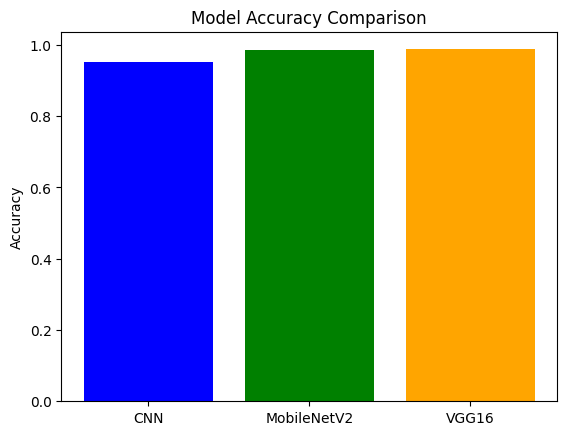

In [20]:
print(f"CNN Accuracy: {cnn_eval[1]:.4f}")
print(f"MobileNet Accuracy: {mobilenet_eval[1]:.4f}")
print(f"VGG16 Accuracy: {vgg16_eval[1]:.4f}")

# Plot accuracy comparison
models = ['CNN', 'MobileNetV2', 'VGG16']
accuracies = [cnn_eval[1], mobilenet_eval[1], vgg16_eval[1]]

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

In [21]:
from tensorflow.keras.models import load_model

# Load the model
model_path = "cnn_model.h5"
cnn_model = load_model(model_path)

model_path = "mobilenet_model.h5"
mobilenet_model = load_model(model_path)

model_path = "vgg16_model.h5"
vgg16_model = load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


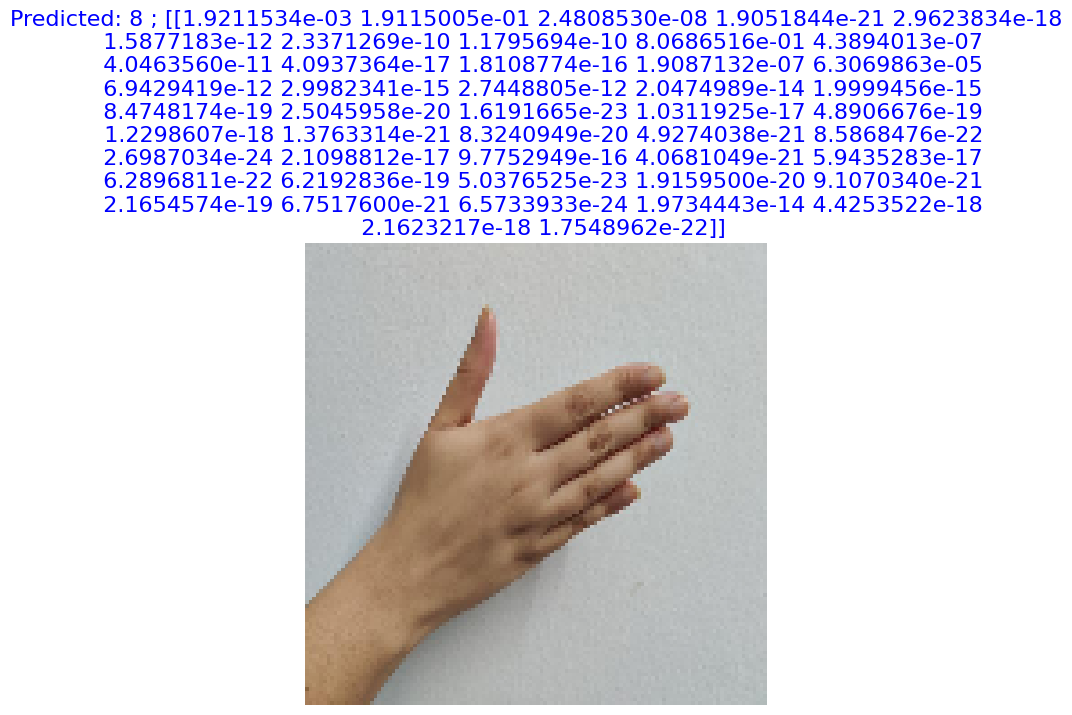

In [22]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Preprocess the image
IMG_SIZE = 128
image_path = "./Dataset/User 01 - Female, 24/sign01/sign01 (11).jpg"
img = cv2.imread(image_path)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize the image
img_normalized = img_resized / 255.0  # Normalize
input_data = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

# Predict the class
predictions = cnn_model.predict(input_data)
predicted_class_index = np.argmax(predictions)


# Plot the image with the predicted label
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title(f"Predicted: {predicted_class_index} ; {predictions}", fontsize=16, color='blue')
plt.axis('off')  # Hide axes
plt.show()
